In [1]:
import pandas as pd 
import numpy as np 
import os 
import sys
import re
import json 
import string

In [2]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adithisatish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
wikivoyage_dir = "../../../../european-city-data/data-sources/wikivoyage/listings/"
cities = pd.read_csv("../../../../european-city-data/archive/city_abstracts_embeddings.csv")

In [4]:
listings = pd.read_csv(f"{wikivoyage_dir}/wikivoyage-listings-cleaned.csv")
things_to_do = listings[listings['type'].isin(['do', 'see', 'go'])]

things_to_do = things_to_do[things_to_do['description'] != "No description found."]
things_to_do['description_processed'] = things_to_do['title'] + ": " + things_to_do['description']
things_to_do.dropna(subset=['description_processed'], inplace=True)

In [5]:
things_to_do.head()

,city,type,title,description,description_processed
0,Aalborg,see,Aalborg Akvavit,Distillery.,Aalborg Akvavit: Distillery.
1,Aalborg,see,Aalborghus Castle,A castle and garden from the 16th century.,Aalborghus Castle: A castle and garden from th...
3,Aalborg,see,Aalborg Townhall,Built in 1759.,Aalborg Townhall: Built in 1759.
4,Aalborg,see,Aalborg Zoo,"Cosy zoo with many ""classic"" zoo animals such ...","Aalborg Zoo: Cosy zoo with many ""classic"" zoo ..."
8,Aalborg,see,Elbjørn,Icebreaker now working as a restaurant and cul...,Elbjørn: Icebreaker now working as a restauran...


In [6]:
def preprocess(text):
    # Lowercase the text
    try:
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Tokenize and remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        # Rejoin the tokens into a string
        return ' '.join(tokens)
    except Exception as e: 
        print(text)
        return ''

things_to_do['description_processed'] = things_to_do['description_processed'].apply(preprocess)

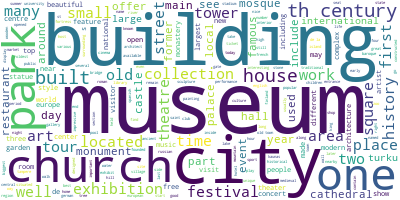

In [7]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(things_to_do['description_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [8]:
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = things_to_do.description_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words)

In [9]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1)]


In [10]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.012*"museum" + 0.010*"church" + 0.009*"built" + 0.008*"city" + '
  '0.007*"also" + 0.006*"one" + 0.006*"theatre" + 0.003*"national" + '
  '0.003*"main" + 0.003*"first"'),
 (1,
  '0.010*"th" + 0.010*"century" + 0.009*"park" + 0.008*"art" + 0.008*"museum" '
  '+ 0.007*"city" + 0.005*"church" + 0.004*"one" + 0.004*"building" + '
  '0.004*"built"'),
 (2,
  '0.009*"museum" + 0.006*"one" + 0.005*"city" + 0.005*"also" + 0.004*"park" + '
  '0.004*"th" + 0.003*"summer" + 0.003*"history" + 0.003*"island" + '
  '0.003*"place"'),
 (3,
  '0.011*"church" + 0.009*"mosque" + 0.007*"tower" + 0.006*"built" + '
  '0.005*"cathedral" + 0.005*"st" + 0.005*"old" + 0.005*"museum" + 0.005*"th" '
  '+ 0.005*"century"'),
 (4,
  '0.010*"church" + 0.006*"century" + 0.006*"museum" + 0.005*"th" + '
  '0.005*"one" + 0.005*"also" + 0.004*"built" + 0.004*"town" + 0.004*"old" + '
  '0.004*"cathedral"'),
 (5,
  '0.008*"museum" + 0.007*"city" + 0.006*"art" + 0.005*"old" + 0.005*"garden" '
  '+ 0.005*"built" + 0.

In [11]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.011471 -0.015347       1        1  14.855791
8      0.018480 -0.033598       2        1  14.250945
0     -0.004772 -0.019616       3        1  12.155103
7     -0.013367 -0.024841       4        1  11.421417
9     -0.066090 -0.043372       5        1  11.282710
3      0.075859 -0.018101       6        1   8.564263
6     -0.014276  0.060457       7        1   7.976305
4      0.045613  0.014260       8        1   7.810960
5     -0.004696  0.037157       9        1   5.948170
2     -0.025280  0.043001      10        1   5.734336, topic_info=         Term        Freq       Total Category  logprob  loglift
35     museum  721.000000  721.000000  Default  30.0000  30.0000
142    mosque  153.000000  153.000000  Default  29.0000  29.0000
89        art  321.000000  321.000000  Default  28.0000  28.0000
673      park  324.000000  324.000000  Default  27.0000  27.0000
601    church  490.000000  490.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
5     century    9.681353  345.731249  Topic10  -6.1146  -0.7168
707  building    9.268437  313.810436  Topic10  -6.1582  -0.6635
601    church    9.958879  490.554524  Topic10  -6.0863  -1.0384
519       old    8.790216  230.857095  Topic10  -6.2112  -0.4095
8       built    9.279960  405.286068  Topic10  -6.1569  -0.9180

[801 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
766        1  0.093018         ad
766        2  0.093018         ad
766        3  0.093018         ad
766        4  0.093018         ad
766        6  0.093018         ad
...      ...       ...        ...
14281      5  0.758755  zrinjevac
14554     10  0.650949    земляні
8828       2  0.297139    каплиця
8828       3  0.594277    каплиця
14548     10  0.445559  троіцькии

[2273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 1, 8, 10, 4, 7, 5, 6, 3])

In [12]:
from bertopic import BERTopic

/Users/adithisatish/TUM/Academics/SoSe24/guided_research/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
docs = things_to_do['description_processed']
# topic_model = BERTopic(nr_topics="auto") # error with bertopic, not fixed yet as 28.08.2024; pip install correct version once fixed: https://github.com/MaartenGr/BERTopic/issues/2100
topic_model = BERTopic(nr_topics=11, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(docs)

In [14]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,896,-1_museum_city_also_building,"[museum, city, also, building, one, park, de, ...",[mercedesbenz museum built astonishing archite...
1,0,599,0_church_built_mosque_century,"[church, built, mosque, century, th, cathedral...",[st marys cathedral oldest church tallinn orig...
2,1,438,1_museum_art_collection_history,"[museum, art, collection, history, de, th, wor...",[museum modern art prefer contemporary art hou...
3,2,320,2_festival_theatre_music_theater,"[festival, theatre, music, theater, cinema, co...",[estate romana festival late june early septem...
4,3,274,3_park_city_pool_also,"[park, city, pool, also, lake, ice, swimming, ...",[grand park along artificial lake people picni...
5,4,67,4_monument_atatrk_memorial_statue,"[monument, atatrk, memorial, statue, war, sovi...",[monument kotsiubinskyi polished black granite...
6,5,44,5_zoo_garden_botanical_species,"[zoo, garden, botanical, species, plants, anim...",[tirana zoo visiting zoo odd experience animal...
7,6,24,6_dublin_irish_pub_tours,"[dublin, irish, pub, tours, tour, city, irelan...",[dublin literary pub crawl ingenious crash cou...
8,7,22,7_football_league_team_stadium,"[football, league, team, stadium, games, clubs...",[tallaght stadium watch shamrock rovers fc soc...
9,8,18,8_bridge_dragon_river_bridges,"[bridge, dragon, river, bridges, road, used, o...",[millennium bridge impressive new bridge morač...


In [15]:
topic_model.visualize_topics()

In [16]:
topic_model.update_topics(docs, n_gram_range=(1, 3))
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,896,-1_museum_city_also_building,"[museum, city, also, building, one, park, th, ...",[mercedesbenz museum built astonishing archite...
1,0,599,0_church_built_mosque_century,"[church, built, mosque, century, th, st, cathe...",[st marys cathedral oldest church tallinn orig...
2,1,438,1_museum_art_collection_history,"[museum, art, collection, history, de, th, wor...",[museum modern art prefer contemporary art hou...
3,2,320,2_festival_theatre_music_theater,"[festival, theatre, music, theater, cinema, co...",[estate romana festival late june early septem...
4,3,274,3_park_city_pool_also,"[park, city, pool, also, lake, ice, swimming, ...",[grand park along artificial lake people picni...
5,4,67,4_monument_atatrk_statue_memorial,"[monument, atatrk, statue, memorial, war, sovi...",[monument kotsiubinskyi polished black granite...
6,5,44,5_zoo_garden_botanical_botanical garden,"[zoo, garden, botanical, botanical garden, spe...",[tirana zoo visiting zoo odd experience animal...
7,6,24,6_dublin_irish_city_tours,"[dublin, irish, city, tours, tour, pub, irelan...",[dublin literary pub crawl ingenious crash cou...
8,7,22,7_football_league_team_stadium,"[football, league, team, stadium, games, clubs...",[tallaght stadium watch shamrock rovers fc soc...
9,8,18,8_bridge_river_dragon_bridges,"[bridge, river, dragon, bridges, dragon bridge...",[millennium bridge impressive new bridge morač...


In [17]:
new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")

In [18]:
topic_model.update_topics(docs, topics=new_topics)

2024-10-14 15:14:15,248 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [19]:
topics_df = topic_model.get_topic_info()

In [20]:
topics_df.head()

,Topic,Count,Name,Representation,Representative_Docs
0,0,902,0_church_built_th_century,"[church, built, th, century, mosque, cathedral...",[st marys cathedral oldest church tallinn orig...
1,1,672,1_museum_art_collection_history,"[museum, art, collection, history, de, exhibit...",[museum modern art prefer contemporary art hou...
2,2,446,2_festival_theatre_music_theater,"[festival, theatre, music, theater, internatio...",[estate romana festival late june early septem...
3,3,503,3_park_city_lake_also,"[park, city, lake, also, pool, one, area, plac...",[grand park along artificial lake people picni...
4,4,67,4_monument_atatrk_memorial_statue,"[monument, atatrk, memorial, statue, war, sovi...",[monument kotsiubinskyi polished black granite...


In [21]:
topics_df['label'] = topics_df['Name'].apply(lambda x: '_'.join(x.split("_")[1:]))
topics_df.head(11)

,Topic,Count,Name,Representation,Representative_Docs,label
0,0,902,0_church_built_th_century,"[church, built, th, century, mosque, cathedral...",[st marys cathedral oldest church tallinn orig...,church_built_th_century
1,1,672,1_museum_art_collection_history,"[museum, art, collection, history, de, exhibit...",[museum modern art prefer contemporary art hou...,museum_art_collection_history
2,2,446,2_festival_theatre_music_theater,"[festival, theatre, music, theater, internatio...",[estate romana festival late june early septem...,festival_theatre_music_theater
3,3,503,3_park_city_lake_also,"[park, city, lake, also, pool, one, area, plac...",[grand park along artificial lake people picni...,park_city_lake_also
4,4,67,4_monument_atatrk_memorial_statue,"[monument, atatrk, memorial, statue, war, sovi...",[monument kotsiubinskyi polished black granite...,monument_atatrk_memorial_statue
5,5,44,5_zoo_garden_botanical_species,"[zoo, garden, botanical, species, plants, anim...",[tirana zoo visiting zoo odd experience animal...,zoo_garden_botanical_species
6,6,24,6_dublin_irish_pub_tours,"[dublin, irish, pub, tours, tour, city, irelan...",[dublin literary pub crawl ingenious crash cou...,dublin_irish_pub_tours
7,7,22,7_football_league_team_stadium,"[football, league, team, stadium, games, clubs...",[tallaght stadium watch shamrock rovers fc soc...,football_league_team_stadium
8,8,18,8_bridge_dragon_river_bridges,"[bridge, dragon, river, bridges, road, used, o...",[millennium bridge impressive new bridge morač...,bridge_dragon_river_bridges
9,9,17,9_marathon_nurmi_run_paavo,"[marathon, nurmi, run, paavo, event, race, tur...",[paavo nurmi games first paavo nurmi games arr...,marathon_nurmi_run_paavo


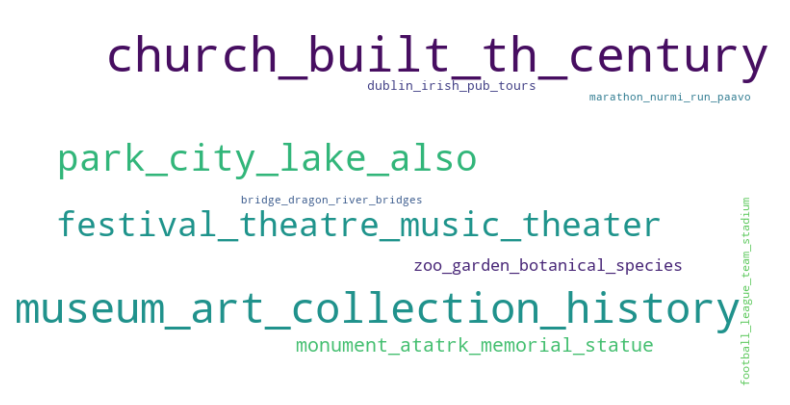

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Convert the labels and counts into a dictionary
word_freq = dict(zip(topics_df['label'], topics_df['Count']))

# Create the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
).generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [23]:
topic_model.save("wikivoyage_listings_topics", serialization="pickle")

2024-10-14 15:14:16,165 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [24]:
for i in topics_df['Representation']:
    print(i)

['church', 'built', 'th', 'century', 'mosque', 'cathedral', 'building', 'tower', 'st', 'city']
['museum', 'art', 'collection', 'history', 'de', 'exhibitions', 'th', 'works', 'building', 'gallery']
['festival', 'theatre', 'music', 'theater', 'international', 'concerts', 'cinema', 'turku', 'opera', 'held']
['park', 'city', 'lake', 'also', 'pool', 'one', 'area', 'place', 'small', 'tour']
['monument', 'atatrk', 'memorial', 'statue', 'war', 'soviet', 'donetsk', 'sculpture', 'killed', 'pedestal']
['zoo', 'garden', 'botanical', 'species', 'plants', 'animals', 'area', 'university', 'park', 'tropical']
['dublin', 'irish', 'pub', 'tours', 'tour', 'city', 'ireland', 'history', 'cork', 'jeanie']
['football', 'league', 'team', 'stadium', 'games', 'clubs', 'home', 'play', 'rugby', 'ireland']
['bridge', 'dragon', 'river', 'bridges', 'road', 'used', 'old', 'two', 'calatrava', 'calendar']
['marathon', 'nurmi', 'run', 'paavo', 'event', 'race', 'turku', 'competition', 'km', 'tennis']


- Historic Religious Buildings: ['church', 'built', 'th', 'century', 'mosque', 'cathedral', 'building', 'st', 'tower', 'city']
- Museums and Art Galleries: ['museum', 'art', 'collection', 'history', 'de', 'exhibitions', 'th', 'building', 'works', 'century']
- Music, Theater and Cultural Festivals: ['festival', 'theatre', 'music', 'theater', 'concerts', 'international', 'cinema', 'opera', 'jazz', 'film']
- Parks and Natural Spaces: ['park', 'city', 'lake', 'also', 'tour', 'one', 'pool', 'area', 'place', 'small']
- Zoos and Wildlife: ['zoo', 'animals', 'species', 'berlin', 'park', 'aquarium', 'children', 'zoos', 'monkeys', 'wilhelma']
- Markets and Fairs: ['turku', 'christmas', 'fair', 'marathon', 'nurmi', 'event', 'run', 'paavo', 'market', 'competition']
- Sport: ['football', 'team', 'stadium', 'league', 'games', 'clubs', 'home', 'play', 'match', 'rugby']
- Bridges and Landmarks: ['bridge', 'river', 'dragon', 'bridges', 'road', 'old', 'used', 'two', 'calendar', 'arch']
- Tropical and Botanical Gardens: ['garden', 'botanical', 'plants', 'species', 'university', 'tropical', 'trees', 'greenhouse', 'botanic', 'arboretum']
- Archaeological and Ancient Ruins: ['roman', 'pompeii', 'ad', 'vesuvius', 'city', 'site', 'rd', 'archeological', 'bc', 'ancient']

In [25]:
topic_labels = {
    0: "Historic Religious Buildings",
    1: "Museums and Art Galleries",
    2: "Music, Theater and Cultural Festivals",
    3: "Parks and Natural Spaces",
    4: "Zoos and Wildlife",
    5: "Markets and Fairs",
    6: "Sport", 
    7: "Bridges and Landmarks",
    8: "Tropical and Botanical Gardens",
    9: "Archaeological and Ancient Ruins"
}

topic_model.set_topic_labels(topic_labels=topic_labels)

In [26]:
new_topics_df = topic_model.get_topic_info()
new_topics_df

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,902,0_church_built_th_century,Historic Religious Buildings,"[church, built, th, century, mosque, cathedral...",[st marys cathedral oldest church tallinn orig...
1,1,672,1_museum_art_collection_history,Museums and Art Galleries,"[museum, art, collection, history, de, exhibit...",[museum modern art prefer contemporary art hou...
2,2,446,2_festival_theatre_music_theater,"Music, Theater and Cultural Festivals","[festival, theatre, music, theater, internatio...",[estate romana festival late june early septem...
3,3,503,3_park_city_lake_also,Parks and Natural Spaces,"[park, city, lake, also, pool, one, area, plac...",[grand park along artificial lake people picni...
4,4,67,4_monument_atatrk_memorial_statue,Zoos and Wildlife,"[monument, atatrk, memorial, statue, war, sovi...",[monument kotsiubinskyi polished black granite...
5,5,44,5_zoo_garden_botanical_species,Markets and Fairs,"[zoo, garden, botanical, species, plants, anim...",[tirana zoo visiting zoo odd experience animal...
6,6,24,6_dublin_irish_pub_tours,Sport,"[dublin, irish, pub, tours, tour, city, irelan...",[dublin literary pub crawl ingenious crash cou...
7,7,22,7_football_league_team_stadium,Bridges and Landmarks,"[football, league, team, stadium, games, clubs...",[tallaght stadium watch shamrock rovers fc soc...
8,8,18,8_bridge_dragon_river_bridges,Tropical and Botanical Gardens,"[bridge, dragon, river, bridges, road, used, o...",[millennium bridge impressive new bridge morač...
9,9,17,9_marathon_nurmi_run_paavo,Archaeological and Ancient Ruins,"[marathon, nurmi, run, paavo, event, race, tur...",[paavo nurmi games first paavo nurmi games arr...


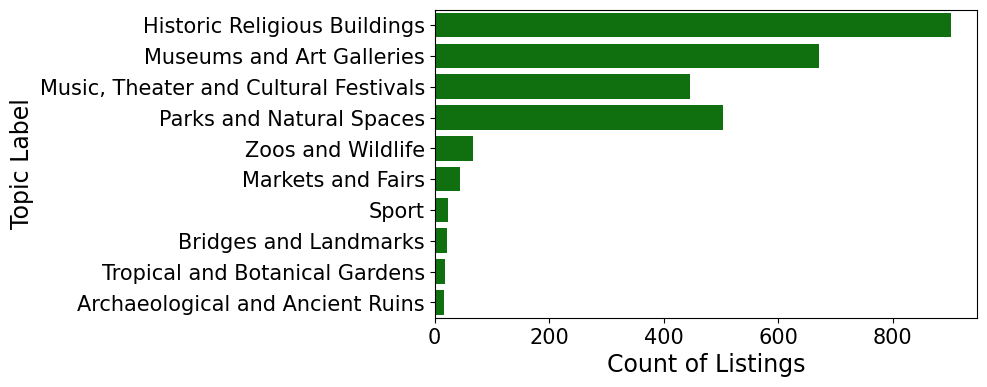

In [27]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(7,4))
plot = sns.barplot(data=new_topics_df, x='Count', y='CustomName', errorbar=None, color='green', orient='h')
# plot.set_title('Topic Labels and their Counts for ', fontsize=15)
# plot.set_xticklabels(['Pleasant', 'Unpleasant', 'Appearance Words', 'Intelligence Words', 'Strength Words', 'Weakness Words'])
plot.set_ylabel(ylabel="Topic Label", fontsize=17)
plot.set_xlabel(xlabel="Count of Listings", fontsize=17)
plot.set_yticklabels(plot.get_yticklabels(), fontsize=15)
plot.set_xticklabels(plot.get_xticklabels(), fontsize=15)
# plot.set_title("Topic Clusters of Attractions for the 160 European cities, generated by BERTopic")
plt.savefig("topic_counts.pdf", bbox_inches='tight')

In [28]:
with open("../../../../european-city-data/data-sources/wikivoyage/original/20053_London.txt", "r") as f:
    london_text = f.read()


In [29]:
with open("../../../../european-city-data/data-sources/wikivoyage/original/26799_Paris.txt", "r") as f:
    paris_text = f.read()

In [30]:
# Step 1: Preprocess the Text
# Convert text to lowercase
def wv_wordcloud(text, city, subplot=False):
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'\W+', ' ', text)

    # Remove stopwords
    stop_words = stopwords.words('english')
    stop_words.extend([
        'lastedit', 'url', 'http', 'https', 'content', 'lat', \
        'long', 'com', 'org', 'alt', 'listing', "fax", "tollfree",\
        "phone", 'email', 'address', 'flag', 'city', 'name', "jpg", "png", \
        "wikidata", 'img', 'image', "arr", "dead link",
        ])
    processed_text = ' '.join(word for word in text.split() if word not in stop_words)

    # Step 2: Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)
    

    # Step 3: Display the WordCloud
    if not subplot:
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        # plt.title(f"Wordcloud of the Wikivoyage Article page for {city}")
        # plt.show()
        plt.savefig(f"wordcloud_{city.lower()}.pdf")
    else:
        return wordcloud

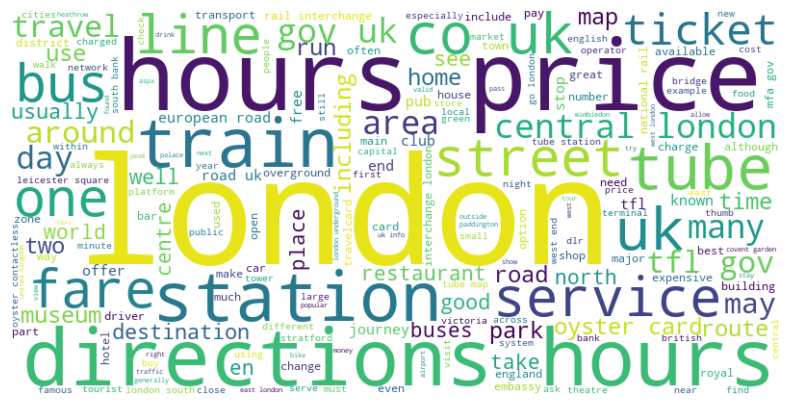

In [31]:
wv_wordcloud(london_text, "London")

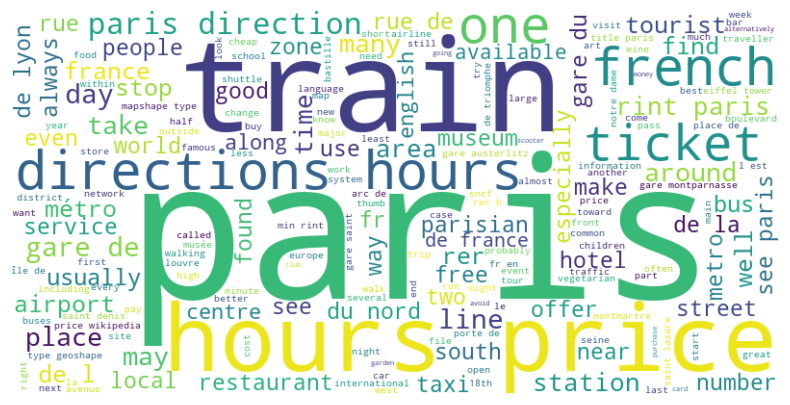

In [32]:
wv_wordcloud(paris_text, "Paris")

In [198]:
with open("../../../../european-city-data/data-sources/wikivoyage/original/29990_Rome.txt", "r") as f:
    rome_text = f.read()

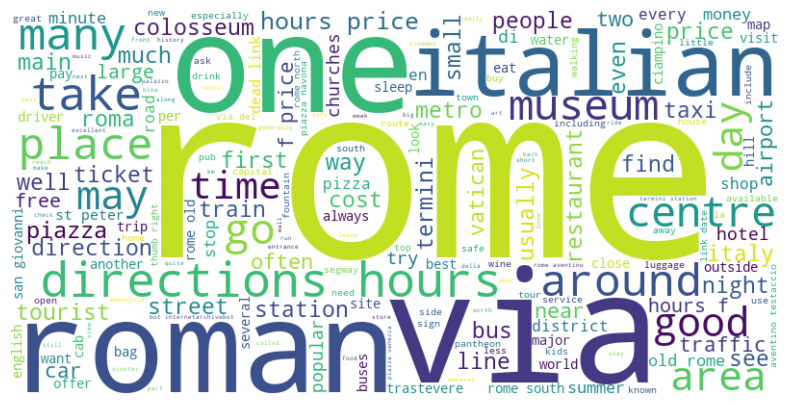

In [199]:
wv_wordcloud(rome_text)

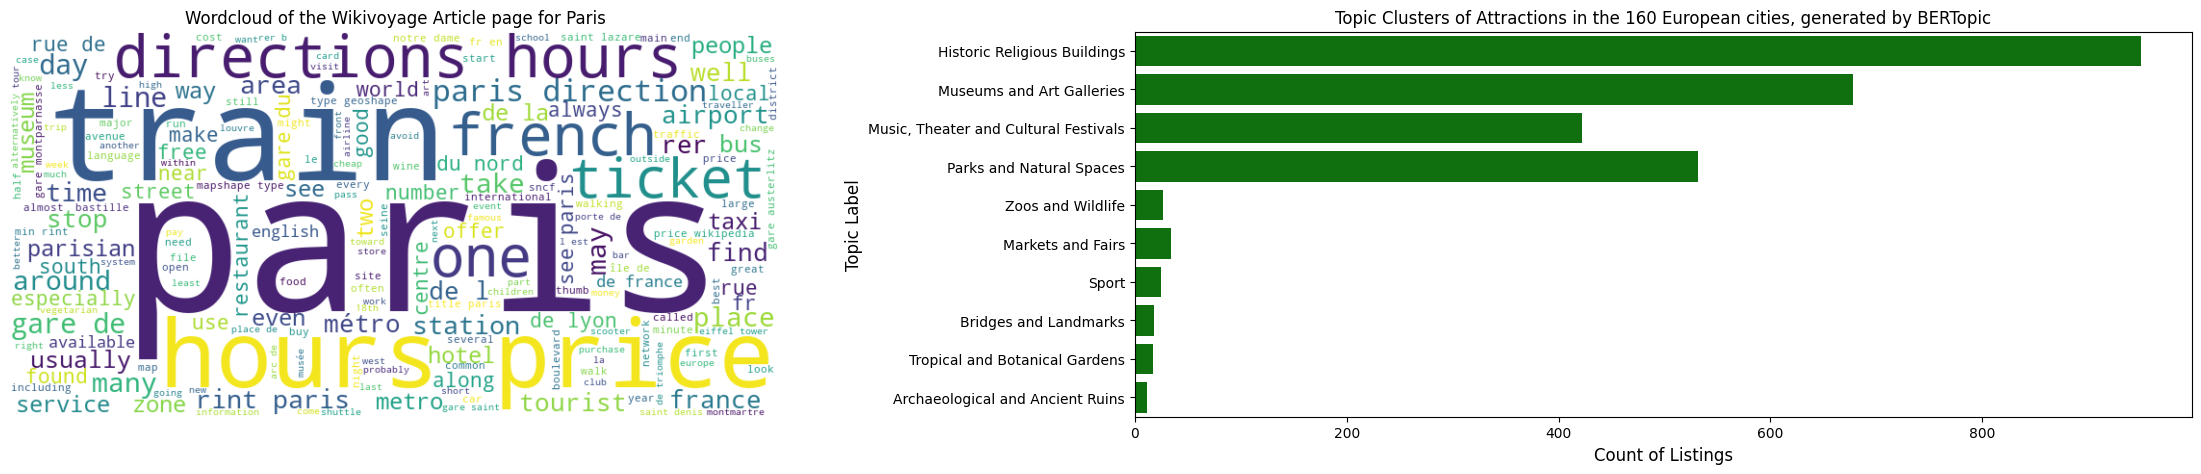

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(30,5), sharey=False)

wordcloud = wv_wordcloud(paris_text, subplot=True)
ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].axis('off')
ax[0].set_title("Wordcloud of the Wikivoyage Article page for Paris")
ax[0].patch.set_edgecolor('black')  
ax[0].patch.set_linewidth(10)  

bar = sns.barplot(ax=ax[1],data=new_topics_df, x='Count', y='CustomName', errorbar=None, color='green', orient='h')
# plot.set_title('Topic Labels and their Counts for ', fontsize=15)
# plot.set_xticklabels(['Pleasant', 'Unpleasant', 'Appearance Words', 'Intelligence Words', 'Strength Words', 'Weakness Words'])
bar.set_ylabel(ylabel="Topic Label", fontsize=12)
bar.set_xlabel(xlabel="Count of Listings", fontsize=12)
bar.set_title("Topic Clusters of Attractions in the 160 European cities, generated by BERTopic")

plt.show()

In [102]:
seasonality = pd.read_csv("../../../../european-city-data/computed/seasonality/seasonality_scores.csv")
popularity = pd.read_csv("../../../../european-city-data/computed/popularity/popularity_scores.csv")

In [103]:
seasonality.head()

,city,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Aalborg,0.016,0.000,0.031,0.173,0.496,0.685,1.000,0.827,0.496,0.378,0.244,0.087
1,Adana,0.000,0.062,0.215,0.757,0.938,0.639,0.875,0.910,0.875,1.000,0.819,0.938
2,Adiyaman,0.000,0.022,0.104,0.433,0.619,0.485,0.918,1.000,0.649,0.649,0.246,0.269
3,Agri,0.000,0.022,0.104,0.433,0.619,0.485,0.918,1.000,0.649,0.649,0.246,0.269
4,Amsterdam,0.434,0.000,0.170,0.132,0.075,0.019,0.642,0.075,1.000,0.943,0.302,0.698


In [104]:
popularity.head()

,city,pois,avg_gt,ugc,normalized_gt,normalized_ugc,normalized_poi,weighted_pop_score
0,Van,40,70.778,4901,1.000,0.001,0.004,0.208
1,Luxembourg,627,69.379,207447,0.980,0.029,0.070,0.244
2,Santander,234,65.812,136209,0.930,0.019,0.026,0.210
3,Maastricht,244,64.644,107940,0.913,0.015,0.027,0.206
4,Kiel,173,62.946,20770,0.889,0.003,0.019,0.193


In [105]:
seasonality[seasonality['city'] == 'Munich']

,city,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
105,Munich,0.038,0.0,0.162,0.015,0.092,0.215,0.192,0.185,1.0,0.315,0.008,0.192


In [107]:
seasonality['total'] = seasonality.iloc[:, -12:-1].sum(axis=1)
seasonality.sort_values(by='total', ascending=False)

,city,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,total
1,Adana,0.000,0.062,0.215,0.757,0.938,0.639,0.875,0.910,0.875,1.000,0.819,0.938,8.028
130,Poznan,0.000,0.246,0.438,0.608,0.854,0.838,0.838,0.815,1.000,0.854,0.477,0.562,7.530
17,Batman,0.000,0.415,0.933,0.963,1.000,0.770,0.741,0.711,0.511,0.452,0.289,0.415,7.200
62,Hamburg,0.152,0.000,0.176,0.592,0.824,0.808,1.000,1.000,0.896,0.744,0.416,0.720,7.176
59,Gaziantep,0.000,0.077,0.317,0.808,1.000,0.683,0.808,0.808,0.654,0.913,0.548,0.529,7.145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Geneva,0.000,0.028,0.056,0.111,0.111,0.167,0.000,0.028,1.000,0.667,0.111,0.333,2.612
105,Munich,0.038,0.000,0.162,0.015,0.092,0.215,0.192,0.185,1.000,0.315,0.008,0.192,2.376
135,Riga,0.293,0.000,0.293,0.049,0.098,0.195,0.024,0.073,0.488,0.073,0.024,1.000,2.317
157,Stockholm,0.126,0.046,0.115,0.069,1.000,0.092,0.000,0.034,0.276,0.161,0.126,0.379,2.298


In [108]:
seasonality[seasonality['city'] == 'Brussels']

,city,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,total
30,Brussels,0.227,0.12,0.187,0.253,0.027,0.04,0.0,0.027,1.0,0.533,0.293,0.773,3.253


In [110]:
popularity.sort_values(by="weighted_pop_score", ascending=False)

,city,pois,avg_gt,ugc,normalized_gt,normalized_ugc,normalized_poi,weighted_pop_score
45,London,8999,29.176,7099844,0.412,1.000,1.000,0.879
39,Paris,8806,34.851,5065682,0.492,0.713,0.979,0.792
41,Rome,6328,34.391,5657815,0.486,0.797,0.703,0.689
37,Barcelona,5062,36.126,3517752,0.510,0.495,0.563,0.530
148,Moscow,8003,0.900,808984,0.013,0.114,0.889,0.457
...,...,...,...,...,...,...,...,...
166,Rivne,48,0.119,1297,0.002,0.000,0.005,0.003
198,Arkhangelsk,0,0.592,9526,0.008,0.001,0.000,0.002
176,Siirt,11,0.008,217,0.000,0.000,0.001,0.001
180,Adiyaman,16,0.004,2113,0.000,0.000,0.002,0.001
